In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
from sklearn.model_selection import train_test_split


In [2]:
#任务1.1 文件读取
info=pd.read_csv('meal_order_info.csv',encoding='GBK')
detail=pd.read_csv('meal_order_detail.csv')

In [3]:
#任务1.2 去掉特殊的字符
newdishname=[]
for i in detail.dishes_name.tolist():
    if '/n' or '/r' in i:
        a=i.replace('\n','').replace('\r','')
        newdishname.append(a)
detail.dishes_name=newdishname

In [4]:
#任务1.3 构建热度函数
def hot_rating(data):
    return (data-data.min())/(data.max()-data.min())


2016年8月销量为：463704


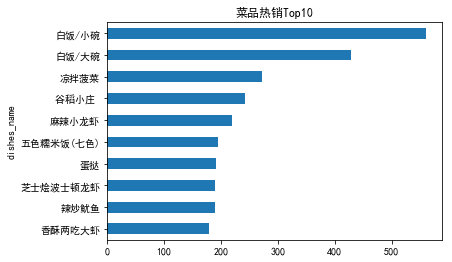

In [5]:
#任务1.4 画图
data=detail[['dishes_name','counts','amounts']]
data.groupby('dishes_name').sum().sort_values(by='counts').tail(10)['counts'].plot.barh(title="菜品热销Top10")
print("2016年8月销量为："+str(sum(data.counts*data.amounts)))

In [6]:
#任务2.1 订单状态占比
info.order_status.value_counts(normalize=True)

1    0.987302
0    0.009524
2    0.003175
Name: order_status, dtype: float64

In [7]:
#任务2.2 选取有效的订单数据
info=info[info.order_status==1]
info=info.drop(['mode','cashier_id','pc_id','order_number','print_doc_bill_num','lock_table_info','check_closed'],axis=1)
detail=detail.drop(['logicprn_name','parent_class_name','cost','discount_amt','discount_reason','kick_back','add_info','bar_code'],axis=1)
detail=detail.drop(index=(detail.loc[(detail['dishes_name']=='白饭/小碗')].index))
detail=detail.drop(index=(detail.loc[(detail['dishes_name']=='白饭/大碗')].index))
#删除在info中没有的订单
drop_list=list(set(detail.order_id.tolist())-set(info.info_id.tolist()))
detail=detail[~detail['order_id'].isin(drop_list)]

In [8]:
#任务2.3 选取主要特征
data2=detail[['dishes_name','emp_id']]

In [9]:
#任务3.1 划分测试集与训练集
data2.emp_id.value_counts()
dish_order=data2.drop_duplicates()
#三个菜以上的顾客名单
customer_list=dish_order.emp_id.value_counts()[dish_order.emp_id.value_counts()>3].index.tolist()
#获取所有菜品名称
dishes_name=list(set(detail.dishes_name))
#按照顾客名单划分测试集与训练集
train_data,test_data=train_test_split(customer_list,test_size=0.3)

In [10]:
#3.2 二维矩阵---函数
def two_dimension(customer_list,dishes_list,df):
    customer_dish=pd.DataFrame(index=customer_list,columns=dishes_list)
    for i in customer_list:
        for j in df[df.emp_id==i].dishes_name.tolist():
            customer_dish.loc[i,j]=1
    customer_dish=customer_dish.fillna(0)
    return customer_dish
    

In [11]:
train_customer_dish=two_dimension(train_data,dishes_name,dish_order)
test_customer_dish=two_dimension(test_data,dishes_name,dish_order)

In [12]:
#任务4 模型构建
class ItemCF:
    def __init__(self,train_TwoMatrix,test_TwoMatrix,n):
        print('-----------模型实例化-----------')
        self.train_TwoMatrix=train_TwoMatrix
        self.test_TwoMatrix=test_TwoMatrix
        self.train_customerID=self.train_TwoMatrix.index.tolist()
        self.test_customerID=self.test_TwoMatrix.index.tolist()
        self.dish=train_TwoMatrix.columns.tolist()
        print('----------生成相似度矩阵---------')
        self.sim_all()
        print('---------相似度矩阵生成完毕-------')
        print('---------生成全顾客推荐列表-------')
        self.recommodation_dic(n)
       
        print('----------全顾客推荐列表生成完毕---------')
    #4.1 相似度
    #欧几里得距离
    def sim_two(self,dish1:list,dish2:list):
        return 1/(1+np.sqrt(((np.array(dish1)-np.array(dish2))**2).sum()))
    def sim_all(self):
        sim_dic={}
        for i in self.train_customerID:
            dish=self.train_TwoMatrix.loc[i,][self.train_TwoMatrix.loc[i,]==1].index.tolist()
            for m1 in dish:
                for m2 in dish:
                    if m1 ==m2:
                        continue
                    sim_dic.setdefault(m1,{})
                    sim_dic[m1].setdefault(m2,0)
                    sim_dic[m1][m2]+=1
        self.sim_dic=pd.DataFrame(sim_dic)
        self.sim_dic=self.sim_dic.fillna(0)
        
        self.sim_matrix=pd.DataFrame(columns=self.dish,index=self.dish)
        for i in range(len(self.sim_matrix.columns)):
            for j in range(len(self.sim_matrix.columns)):
                self.sim_matrix.iloc[i,j]=self.sim_two(self.sim_dic.iloc[:,i].tolist(),self.sim_dic.iloc[:,j].tolist())
        for i in range(self.sim_matrix.shape[1]):
            self.sim_matrix.iloc[i,i]=0
            
        return self.sim_matrix
    
    #4.2 生成推荐字典(根据吃过的菜推荐相似度最高的N个)
    def recommodation_dic(self,n):   
        self.dic={}
        for i in self.test_customerID:
            dish=self.test_TwoMatrix.loc[i,][self.test_TwoMatrix.loc[i,]==1].index.tolist()
            self.dic.setdefault(i,[])
            for j in dish:
                self.sim_matrix.loc[j].sort_values(ascending=False).index.tolist()[0:n]
                self.dic[i].extend(self.sim_matrix.loc[j].sort_values(ascending=False).index.tolist()[0:n])


In [13]:
model=ItemCF(train_customer_dish,test_customer_dish,1)

-----------模型实例化-----------
----------生成相似度矩阵---------
---------相似度矩阵生成完毕-------
---------生成全顾客推荐列表-------
----------全顾客推荐列表生成完毕---------


In [14]:
#5.1构建客户IP字典
customerIP={}
for i in test_customer_dish.index.tolist():
    customerIP[i]=list(test_customer_dish.loc[i,:][test_customer_dish.loc[i,:]==1].index.tolist())


In [15]:
#5.2模型评价

def precise(test_predict_dic,dic):
    all_num=0
    precise=0
    total=0
    for i in list(test_predict_dic.keys()):
        total+=len(test_predict_dic[i])
        for j in test_predict_dic[i]:
            if j in dic[i]:
                precise+=1
    for i in list(dic.keys()):
        all_num+=len(dic[i])
    print('-------------模型效果分析---------------')
    print('客户总喜好个数为',all_num)
    print('总推荐个数为',total)
    print('准确预测的个数为',precise)
    print('预测准确率为',precise/total)
    print('召回率',precise/all_num)
    return precise/total,precise/all_num

In [16]:
pre=[]
rec=[]

a,b=precise(model.dic,customerIP)
pre.append(a)
rec.append(b)

-------------模型效果分析---------------
客户总喜好个数为 2427
总推荐个数为 2427
准确预测的个数为 447
预测准确率为 0.1841779975278121
召回率 0.1841779975278121


In [17]:
#保存推荐字典
import csv
newfile=open('推荐字典.csv','w',newline='')
filewriter=csv.writer(newfile)
for k,v in model.dic.items():
    print(k,v)
    filewriter.writerow([k,v])
newfile.close()

1552 ['泡椒凤爪', '重庆特色油烧兔', '木须豌豆', '肉丁茄子']
1221 ['小炒羊腰', '凉拌海带豆芽紫菜', '法国波尔多AOC干红葡萄酒原', '辣炒田螺', '宝宝版牛肉肠粉', '辣炒田螺', '凉拌蒜蓉西兰花', '白胡椒胡萝卜羊肉汤', '孜然羊排', '长城窖酿解百纳红酒干红葡萄酒', '哈尔滨啤酒罐装', '香辣腐乳炒虾', '冰糖红豆薏米粥', '肉丁茄子', '哈尔滨啤酒罐装', '五香酱驴肉']
1185 ['38度剑南春 ', '爆炒猪肝', '豌豆薯仔猪骨汤', '宝宝版牛肉肠粉', '爆炒猪肝', '辣炒花蛤', '纸杯蛋糕', '长城窖酿解百纳红酒干红葡萄酒', '意文柠檬汁 ', '长城窖酿解百纳红酒干红葡萄酒', '50度古井贡酒', '水煮鱼', '凉拌海带豆芽紫菜', '芹菜炒腰花', '百里香奶油烤紅酒牛肉', '蒜蓉生蚝', '盘蟹蒸蛋', '五彩豆', '青炒扁豆', '三色凉拌手撕兔', '培根花菜', '红酒土豆烧鸭腿', '百里香奶油烤紅酒牛肉']
1289 ['油焖麻辣虾', '宝宝版牛肉肠粉', '凉拌蒜蓉西兰花', '蒜香辣花甲', '桂圆枸杞鸽子汤', '香辣腐乳炒虾', '意文柠檬汁 ', '水煮鱼', '凉拌海带豆芽紫菜', '冰糖红豆薏米粥', '盘蟹蒸蛋', '肉丁茄子', '黄花菜炒木耳', '百里香奶油烤紅酒牛肉', '哈尔滨啤酒罐装']
1391 ['老式面包', '孜然羊排', '桂圆枸杞鸽子汤', '宝宝版牛肉肠粉', '辣炒田螺', '蒜香辣花甲', '长城窖酿解百纳红酒干红葡萄酒', '香辣腐乳炒虾', '谷稻小庄 ', '香辣腐乳炒虾', '意文柠檬汁 ', '长城窖酿解百纳红酒干红葡萄酒', '凉拌海带豆芽紫菜', '清蒸蝶鱼', '百里香奶油烤紅酒牛肉', '盘蟹蒸蛋', '盘蟹蒸蛋', '木须豌豆', '芹菜炒腰花', '桂圆肉红豆八宝饭', '培根花菜', '哈尔滨啤酒罐装']
1251 ['52度泸州老窖 ', '牛尾汤', '法国波尔多AOC干红葡萄酒原', '泡椒凤爪', '孜然羊排', '木须豌豆']
1307 ['蛋挞', '桂圆枸杞鸽子汤', '超人气广式肠粉', '香辣腐乳炒虾', '玉竹南北杏鸭腿汤', '清蒸蝶鱼', '百里香奶油烤紅酒牛